In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [3]:
from KuhnPoker import KuhnPokerModel, KuhnPokerInfoSet, ActionNode, PASS, ADD_CHIP, Card, TensorModel, SamplingNode
from ISMCTS import Tree, Constants
from AlphaZero import NNModel, SelfPlayDataV, SelfPlayDataP, AlphaZero
from TreeVisualizer import plot_trees

import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from utils import get_max_model_number
import json


import os
from typing import List, Tuple
import ipywidgets as widgets
from IPython.display import display

np.set_printoptions(precision=2)

In [4]:
def load_models(directory) -> Tuple[List[nn.Module], List[nn.Module]]:
    max_vmodel = get_max_model_number(f'{directory}/vmodel')
    max_pmodel = get_max_model_number(f'{directory}/pmodel')
    
    assert max_vmodel == max_pmodel
    
    vmodel = []
    pmodel = []
    
    print('load models')
    for i in tqdm(range(max_vmodel + 1)):
        vmodel.append(torch.load(f'{directory}/vmodel/vmodel-{i}.pt'))
        pmodel.append(torch.load(f'{directory}/pmodel/pmodel-{i}.pt'))
    
    return vmodel, pmodel

def make_df(vmodel: List[nn.Module], pmodel: List[nn.Module]):
    p_info_set = KuhnPokerInfoSet([0], [None, Card.JACK])
    q_info_set = KuhnPokerInfoSet([0, 1], [Card.QUEEN, None])
    j01_info_set = KuhnPokerInfoSet([0, 1], [None, Card.JACK])
    kj01_info_set = KuhnPokerInfoSet([0, 1], [Card.KING, Card.JACK])
    qj01_info_set = KuhnPokerInfoSet([0, 1], [Card.QUEEN, Card.JACK])
    
    ps = []
    qs = []
    vs = []
    vs1 = []
    vs2 = []
    print('make df:')
    for i in tqdm(range(len(vmodel))):
        p = TensorModel(vmodel[i], pmodel[i]).eval_P(ActionNode(p_info_set))[1]
        q = TensorModel(vmodel[i], pmodel[i]).eval_P(ActionNode(q_info_set))[1]

        v, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(SamplingNode(j01_info_set))

        kj_node = ActionNode(kj01_info_set)
        kj_node.spawned_tree = 1
        v1, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(kj_node)

        qj_node = ActionNode(qj01_info_set)
        qj_node.spawned_tree = 1
        v2, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(qj_node)
        ps.append(p)
        qs.append(q)
        vs.append(v)
        vs1.append(v1)
        vs2.append(v2)
        
    df = pd.DataFrame({'p': ps, 'q': qs, 'v_?J[01]': vs, 'v_KJ[01]': vs1, 'v_QJ[01]': vs2})
    
    return df

def load_model_df(directory):
    vmodel, pmodel = load_models(directory)
    return make_df(vmodel, pmodel)

def compute_sample_pq(positions):
    data = []
    for pos in tqdm(positions):
        if pos.policy_target is not None:
            cards = [getattr(c, 'value', -1) for c in pos.info_set.cards]

            data.append([pos.info_set.action_history,
                       cards,
                       pos.policy_target[1],
                       pos.gen_id,
                      ])
    df = pd.DataFrame(data, columns=['action_history', 'cards', 'policy', 'gen_id'])

    p_ix = df['action_history'].apply(lambda x: x == [0]) & df['cards'].apply(lambda x: x == [-1, 0])
    q_ix = df['action_history'].apply(lambda x: x == [0, 1]) & df['cards'].apply(lambda x: x == [1, -1])

    df.loc[p_ix, 'p'] = df.loc[p_ix, 'policy']
    df.loc[q_ix, 'q'] = df.loc[q_ix, 'policy']

    p_hat = df[p_ix].groupby('gen_id')['policy'].mean()
    q_hat = df[q_ix].groupby('gen_id')['policy'].mean()
    
    return p_hat, q_hat

def plot_exp_folder(folder):
    df_model = load_model_df(f'{folder}/')
    data = df_model

    with open(f'{folder}/config.json', 'r') as f:
        config = json.load(f)

    print(config)

    plt.figure(figsize=(8, 6)) 
    plt.plot(data['p'], data['q'], linestyle='-', color='b', alpha=0.5)
    plt.title('Trajectory in p-q Space') 
    plt.xlabel('p')  
    plt.ylabel('q') 
    plt.grid(True) 


    # Annotate every 32nd point with its order number
    for i, (p, q) in enumerate(zip(data['p'], data['q'])):
        if i % 64 == 0:
            plt.text(p, q, str(i), color="red", fontsize=12)

    # Mark the last point with a special marker
    plt.scatter(data['p'].iloc[-1], data['q'].iloc[-1], color='red', s=100, marker='o', label='Last Point')

    # Marking the target point
    plt.scatter([1/3], [1/3], color='green', s=100, marker='x', label='Target (1/3, 1/3)')

    plt.figure(figsize=(10, 8))
    plt.plot(df_model.index, df_model['v_?J[01]'], label='v_?J[01]')
    plt.plot(df_model.index, df_model['v_KJ[01]'], label='v_KJ[01]')
    plt.plot(df_model.index, df_model['v_QJ[01]'], label='v_QJ[01]')

    plt.axhline(y=-1, color='blue', linestyle='--')
    plt.axhline(y=-2, color='orange', linestyle='--')
    plt.axhline(y=0, color='green', linestyle='--')


    plt.legend()
    plt.title('V')

    with open(f'{folder}/positions.pkl', 'rb') as f:
        positions = pickle.load(f)

    p_hat, q_hat = compute_sample_pq(positions)

    plt.figure(figsize=(10, 8))
    plt.plot(p_hat.index, p_hat,'x', color='green', label='p_hat', alpha=0.5)
    plt.plot(q_hat.index, q_hat, '+', color = 'orange', label='q_hat', alpha=0.5)
    plt.plot(df_model.index, df_model['p'], 'o', markersize=4, color='blue', label='p', alpha=0.3)
    plt.plot(df_model.index, df_model['q'], '^', markersize=4, color='red', label='q', alpha=0.3)
    plt.axhline(y=1/3, color='r', linestyle='--')
    plt.legend()
    plt.title('p, q N-dist')
    plt.show()

load models


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1509/1509 [00:00<00:00, 1958.63it/s]


make df:


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1509/1509 [00:01<00:00, 1132.84it/s]


{'load_and_resume': True, 'iter': 1000, 'eps': 0.0, 'c_PUCT': 0.1, 'Dirichlet_ALPHA': 1.0, 'num_gens': 2048, 'num_games_per_gen': 32, 'processes': 8}


<IPython.core.display.Javascript object>


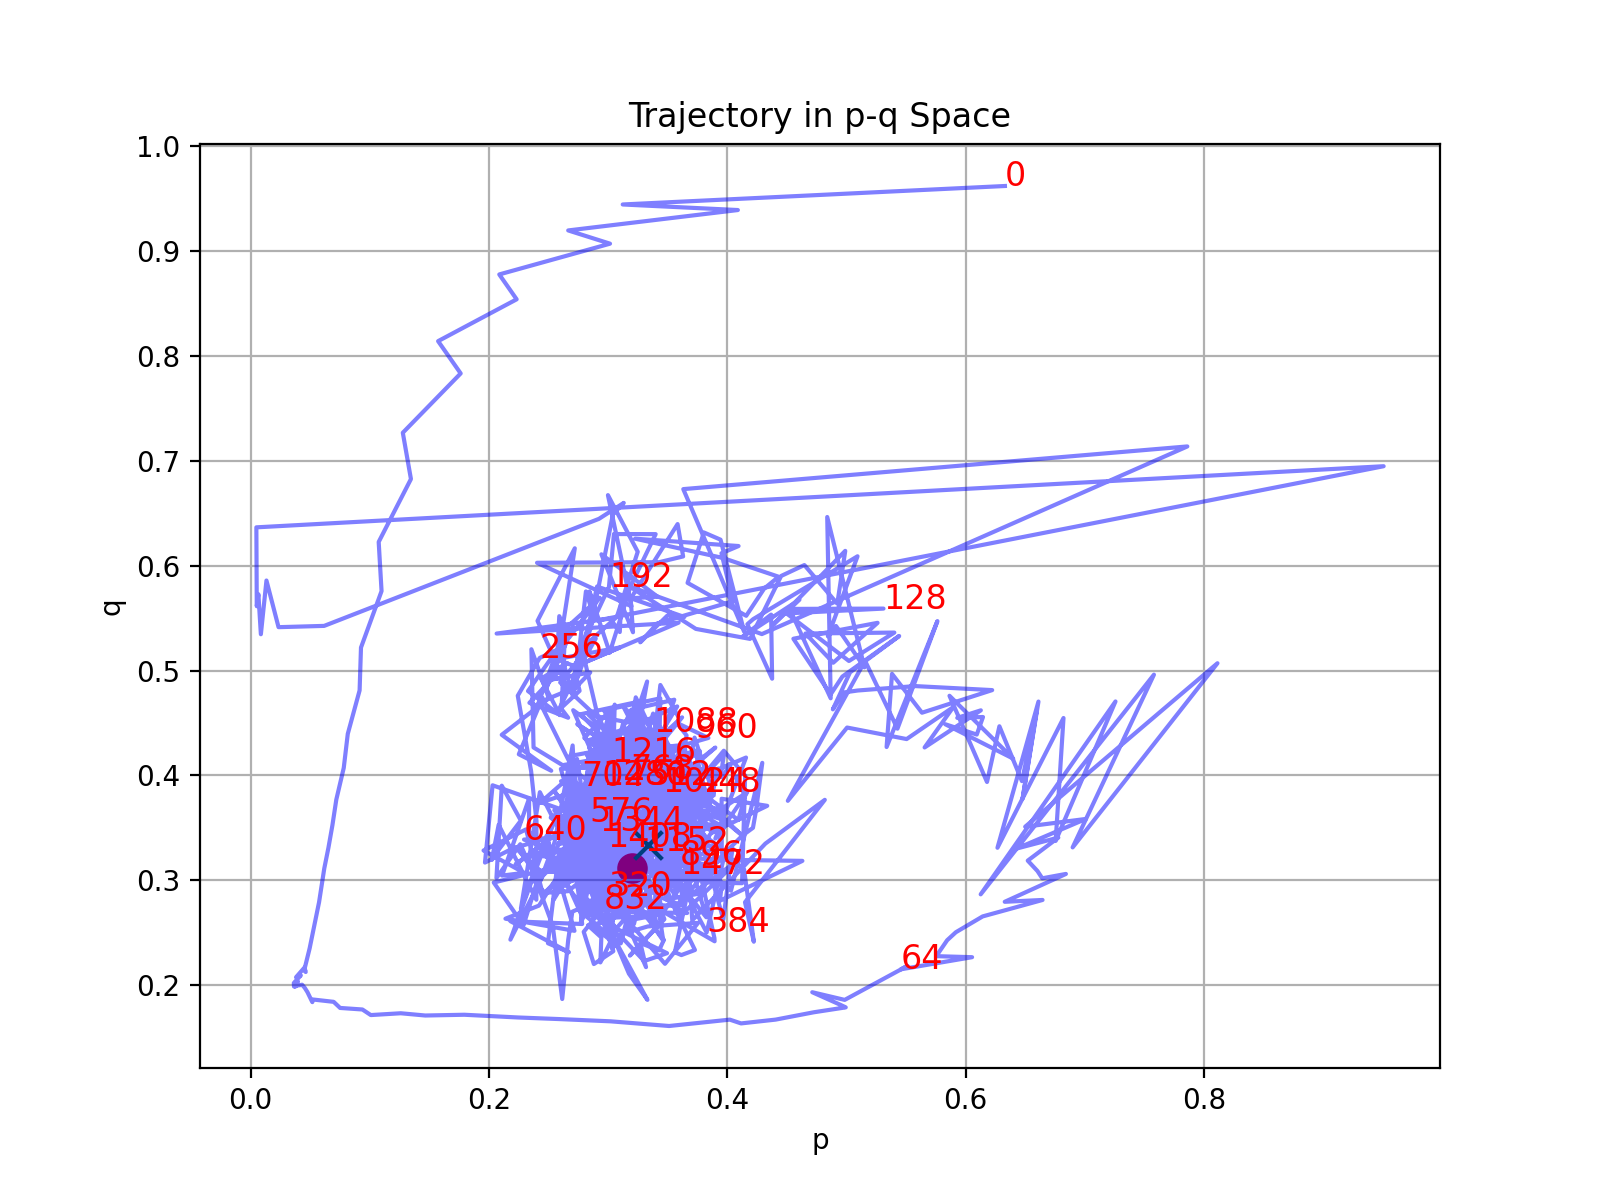

<IPython.core.display.Javascript object>


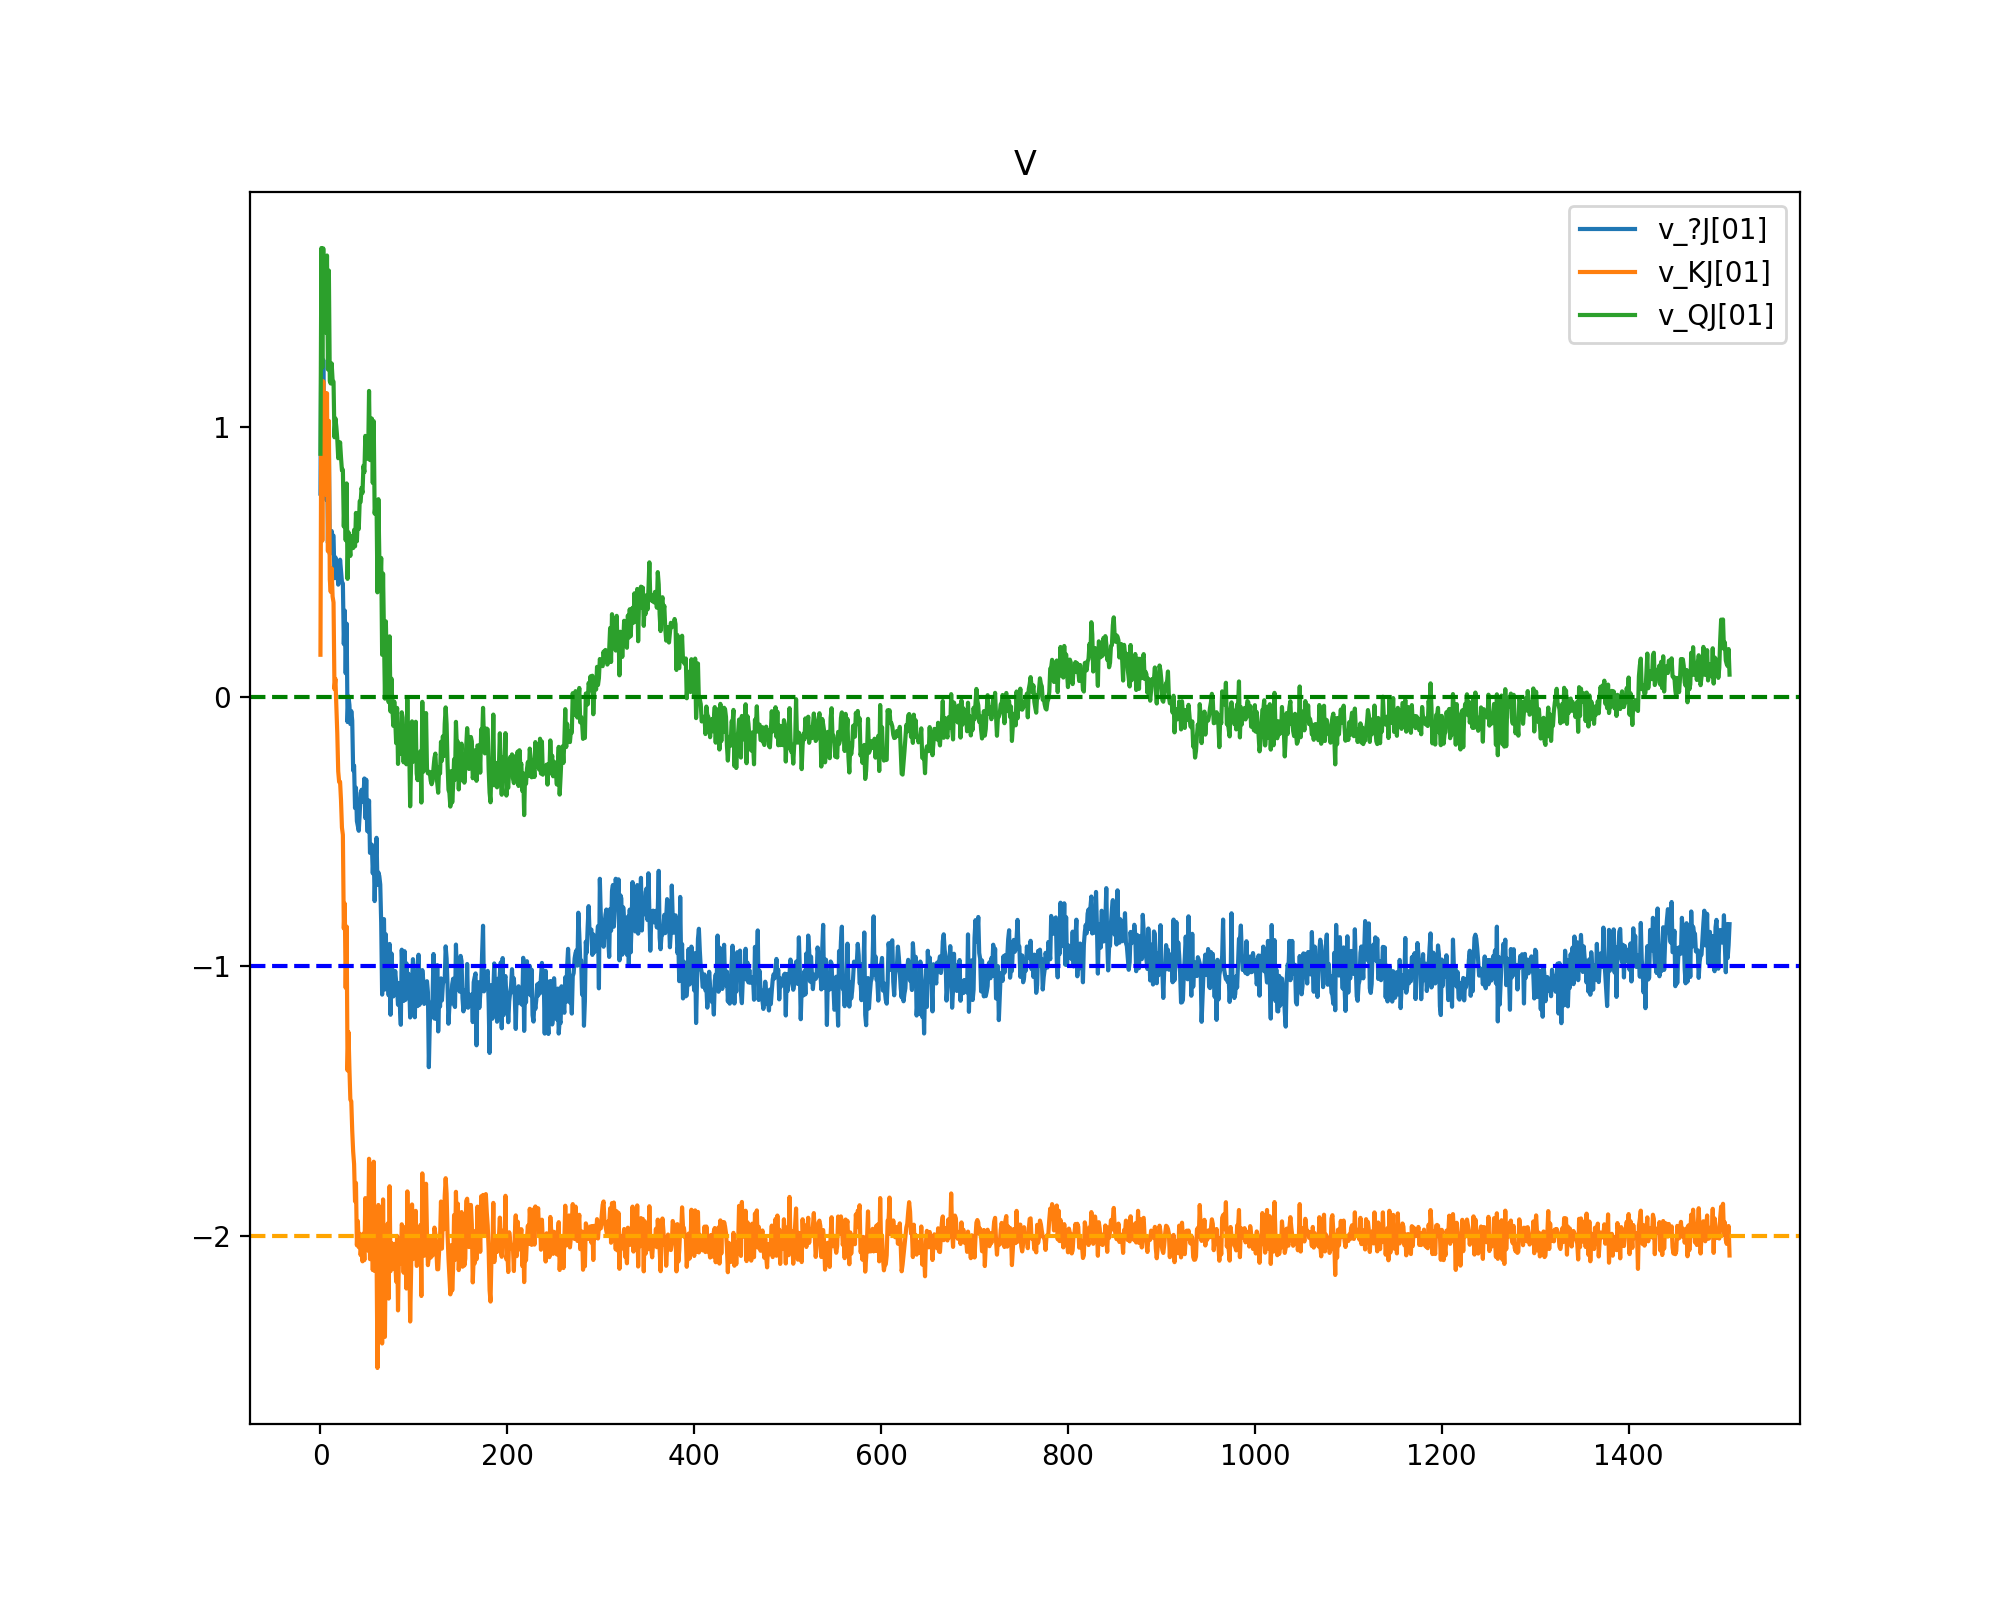

100%|██████████████████████████████████████████████████████████████████████████████████| 318869/318869 [00:00<00:00, 3842250.25it/s]


<IPython.core.display.Javascript object>


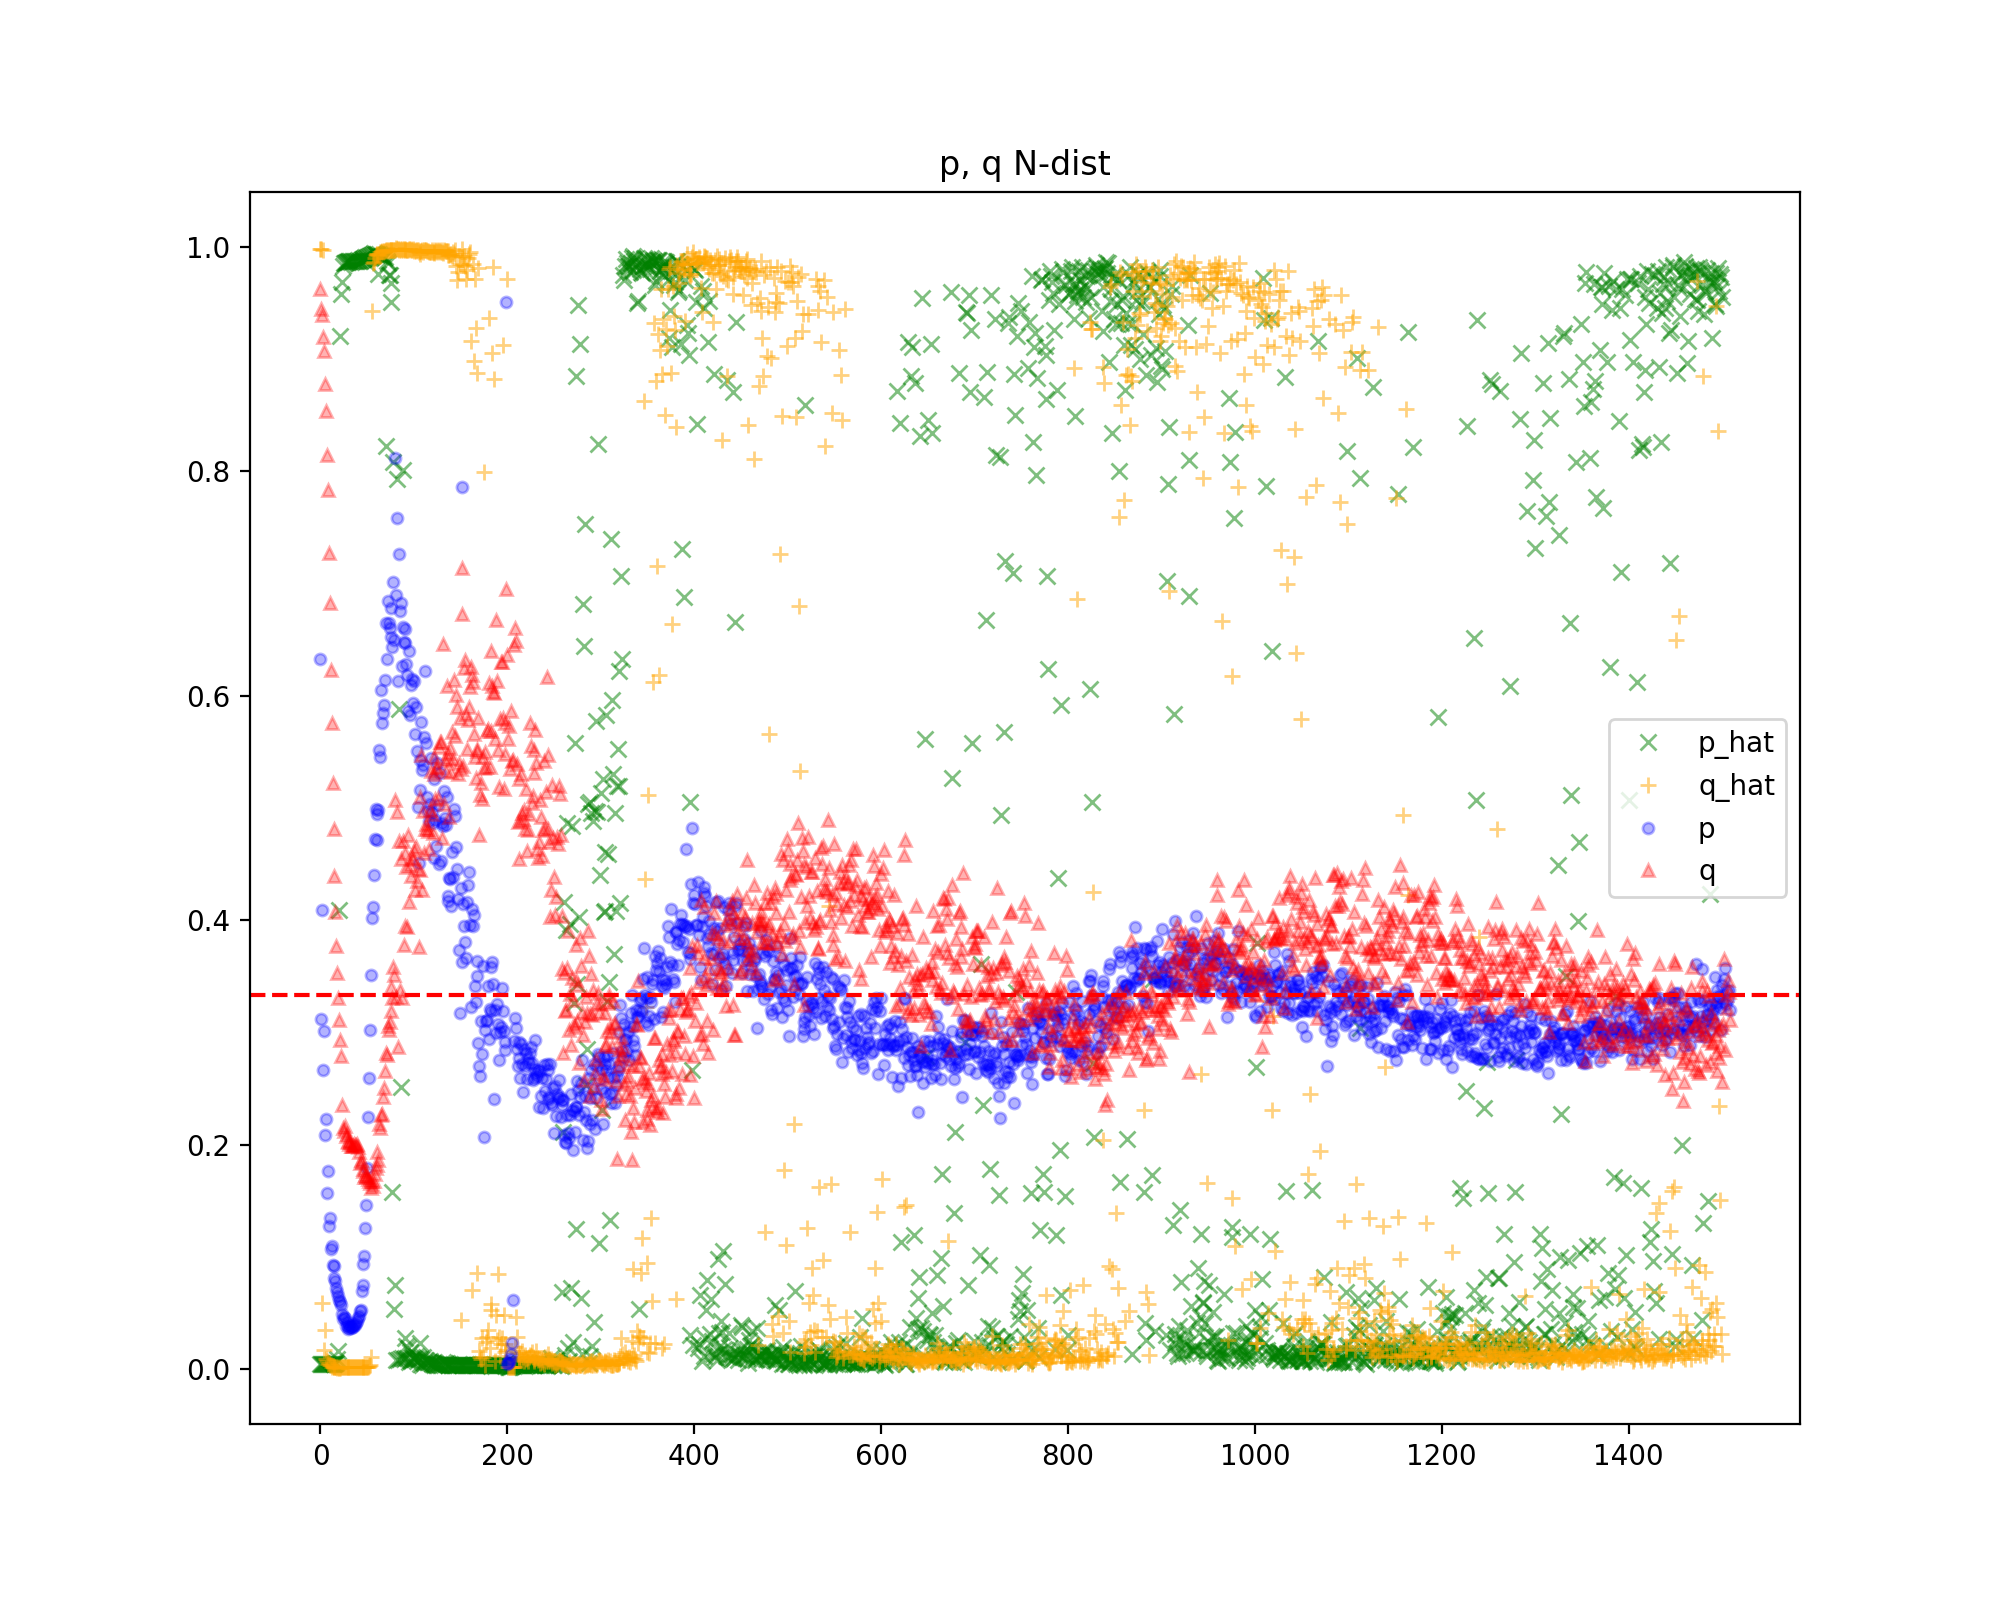

In [5]:
plot_exp_folder('example')